In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from models.model_blocks import ConvBlock
import lib.visualizations as visualizations
import lib.setup_model as setup_model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
Trainer = __import__('base.baseTrainer')

exp_path = "/home/user/villar/ObjectCentricVideoPred/experiments/SynpickExps/InstanceSeg1"

In [4]:
trainer = Trainer.baseTrainer.BaseTrainer(exp_path)
trainer.load_data()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 545965/545965 [00:03<00:00, 136752.97it/s]


Examples in training set: 77650
SynpickVP test-sequences have 50 frames. Your num_frames = 6 will be overridden


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31293/31293 [00:00<00:00, 35304.93it/s]

Examples in validation set: 121


## Data

In [5]:
videos, all_reps = batch_data = next(iter(trainer.train_loader))

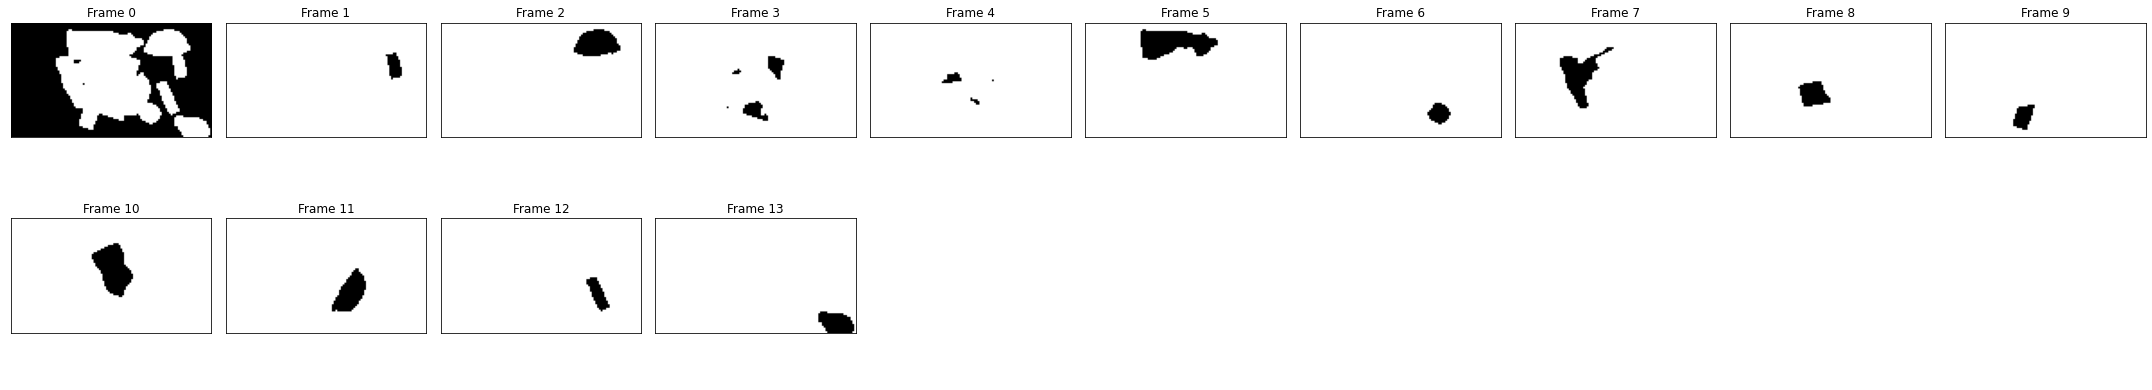

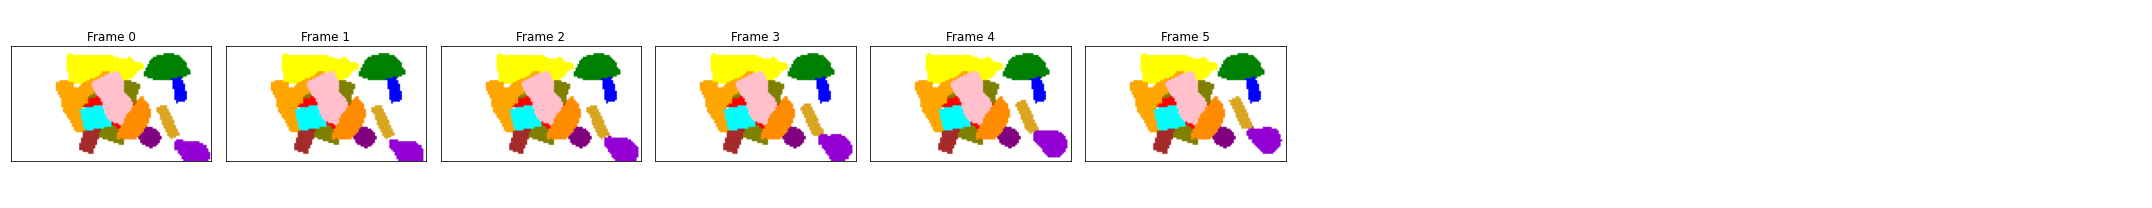

In [6]:
_ = visualizations.visualize_sequence(videos[0, 0].detach(), n_cols=10, add_axis=False, n_channels=1, cmap="gray_r")
masks_rgb = visualizations.one_hot_instances_to_rgb(videos.detach().float(), num_channels=14)
_ = visualizations.visualize_sequence(masks_rgb[0])

## Model

In [7]:
model = setup_model.setup_model(model_params=trainer.exp_params["model"])

Initializer:
  --> mode=Masks
  --> slot_dim=128
  --> num_slots=14
resolution: (8, 14) , hidden_size: 32
Encoder:
  --> Encoder_type=ConvEncoder
  --> Downsample_encoder=True
  --> in_channels=1
  --> num_channels=[32, 64, 128, 256]
  --> kernel_size=5
Fusion Model:
Decoder:
  --> Resolution=[8, 14]
  --> Num channels=[32, 64, 128, 256]
  --> Upsample=2
  --> Downsample_encoder=True
  --> Downsample_decoder=True
  --> Decoder_resolution=[4, 7]
resolution: [4, 7] , hidden_size: 128


In [14]:
videos, all_reps = batch_data = next(iter(trainer.train_loader))

slots, recons = model(videos.float(), num_imgs=6)
assert recons.shape == videos.shape

## Training Test

In [31]:
model = setup_model.setup_model(model_params=trainer.exp_params["model"])
model = model.cuda()

Initializer:
  --> mode=Masks
  --> slot_dim=128
  --> num_slots=14
resolution: (8, 14) , hidden_size: 32
Encoder:
  --> Encoder_type=ConvEncoder
  --> Downsample_encoder=True
  --> in_channels=1
  --> num_channels=[32, 64, 128, 256]
  --> kernel_size=5
Fusion Model:
Decoder:
  --> Resolution=[8, 14]
  --> Num channels=[32, 64, 128, 256]
  --> Upsample=2
  --> Downsample_encoder=True
  --> Downsample_decoder=True
  --> Decoder_resolution=[4, 7]
resolution: [4, 7] , hidden_size: 128


In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [35]:
for _ in range(5):
    losses = []
    for i, (videos, all_reps) in enumerate(tqdm(trainer.train_loader)):
        imgs = videos.float().cuda()

        slots, recons = model(imgs, num_imgs=imgs.shape[1])
        loss = F.mse_loss(recons, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if i % 200 == 0 and i > 0:
            print(f"Curr Loss: {loss.item():.5f}")
            print(f"Mean Loss: {np.mean(losses[-50:]):.5f}")

  4%|████▊                                                                                                                | 201/4854 [01:18<28:45,  2.70it/s]

Curr Loss: 0.03085
Mean Loss: 0.03575


  8%|█████████▋                                                                                                           | 401/4854 [02:37<29:43,  2.50it/s]

Curr Loss: 0.02591
Mean Loss: 0.02687


 12%|██████████████▍                                                                                                      | 601/4854 [03:57<28:19,  2.50it/s]

Curr Loss: 0.02390
Mean Loss: 0.02352


 17%|███████████████████▎                                                                                                 | 801/4854 [05:17<26:21,  2.56it/s]

Curr Loss: 0.02590
Mean Loss: 0.02394


 21%|███████████████████████▉                                                                                            | 1001/4854 [06:34<24:11,  2.65it/s]

Curr Loss: 0.02488
Mean Loss: 0.02238


 25%|████████████████████████████▋                                                                                       | 1201/4854 [07:54<23:47,  2.56it/s]

Curr Loss: 0.02166
Mean Loss: 0.02078


 29%|█████████████████████████████████▍                                                                                  | 1401/4854 [09:14<22:54,  2.51it/s]

Curr Loss: 0.01870
Mean Loss: 0.02063


 33%|██████████████████████████████████████▎                                                                             | 1601/4854 [10:34<22:18,  2.43it/s]

Curr Loss: 0.01705
Mean Loss: 0.01870


 37%|███████████████████████████████████████████                                                                         | 1801/4854 [11:52<20:34,  2.47it/s]

Curr Loss: 0.01876
Mean Loss: 0.01860


 41%|███████████████████████████████████████████████▊                                                                    | 2001/4854 [13:11<20:15,  2.35it/s]

Curr Loss: 0.01608
Mean Loss: 0.01789


 45%|████████████████████████████████████████████████████▌                                                               | 2201/4854 [14:32<17:06,  2.58it/s]

Curr Loss: 0.02054
Mean Loss: 0.01861


 49%|█████████████████████████████████████████████████████████▍                                                          | 2401/4854 [15:52<16:13,  2.52it/s]

Curr Loss: 0.01681
Mean Loss: 0.01880


 54%|██████████████████████████████████████████████████████████████▏                                                     | 2601/4854 [17:11<14:24,  2.61it/s]

Curr Loss: 0.01670
Mean Loss: 0.01731


 58%|██████████████████████████████████████████████████████████████████▉                                                 | 2801/4854 [18:33<13:41,  2.50it/s]

Curr Loss: 0.01909
Mean Loss: 0.01770


 62%|███████████████████████████████████████████████████████████████████████▋                                            | 3001/4854 [19:54<12:19,  2.51it/s]

Curr Loss: 0.01337
Mean Loss: 0.01704


 66%|████████████████████████████████████████████████████████████████████████████▍                                       | 3201/4854 [21:14<10:56,  2.52it/s]

Curr Loss: 0.01744
Mean Loss: 0.01639


 70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 3401/4854 [22:35<09:24,  2.58it/s]

Curr Loss: 0.01715
Mean Loss: 0.01628


 74%|██████████████████████████████████████████████████████████████████████████████████████                              | 3601/4854 [23:55<08:05,  2.58it/s]

Curr Loss: 0.01584
Mean Loss: 0.01628


 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 3801/4854 [25:17<07:41,  2.28it/s]

Curr Loss: 0.01615
Mean Loss: 0.01660


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4001/4854 [26:38<05:49,  2.44it/s]

Curr Loss: 0.01517
Mean Loss: 0.01588


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 4201/4854 [27:59<04:32,  2.39it/s]

Curr Loss: 0.01640
Mean Loss: 0.01638


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4401/4854 [29:21<03:02,  2.48it/s]

Curr Loss: 0.01694
Mean Loss: 0.01537


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4601/4854 [30:44<01:43,  2.44it/s]

Curr Loss: 0.01359
Mean Loss: 0.01427


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 4801/4854 [32:08<00:21,  2.51it/s]

Curr Loss: 0.01951
Mean Loss: 0.01570


  0%|                                                                                                                       | 5/4854 [00:02<35:51,  2.25it/s]


KeyboardInterrupt: 

In [36]:
videos, all_reps = batch_data = next(iter(trainer.train_loader))
imgs = videos.float().cuda()

slots, recons = model(imgs, num_imgs=6)

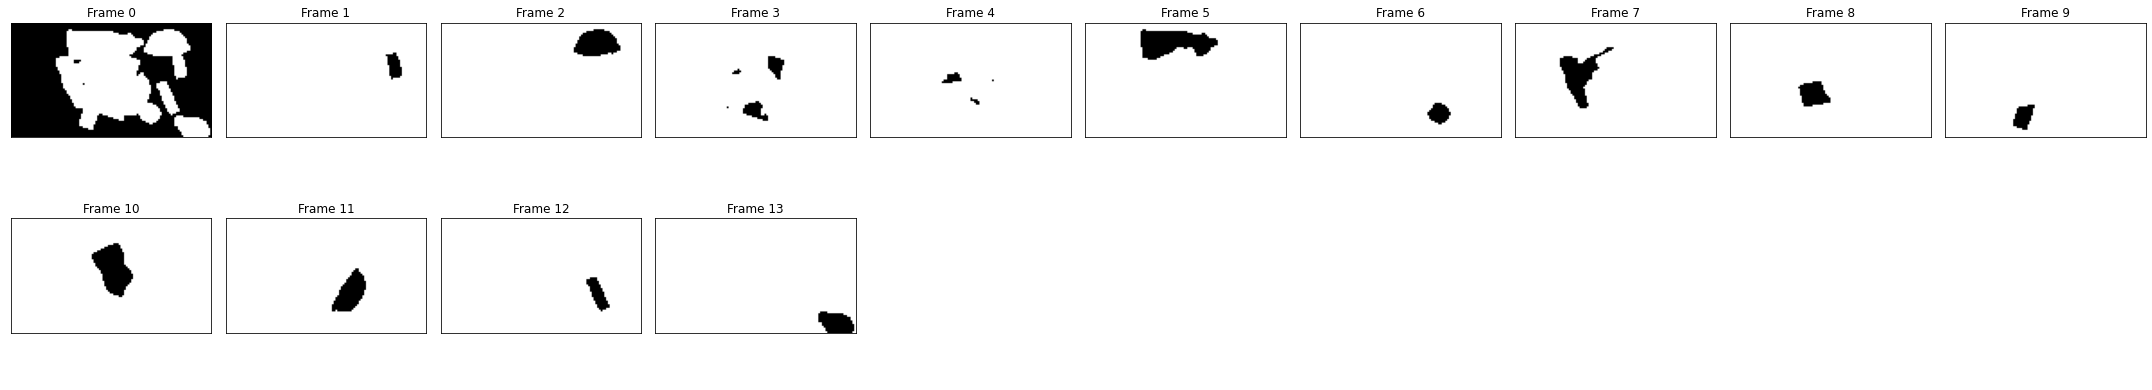

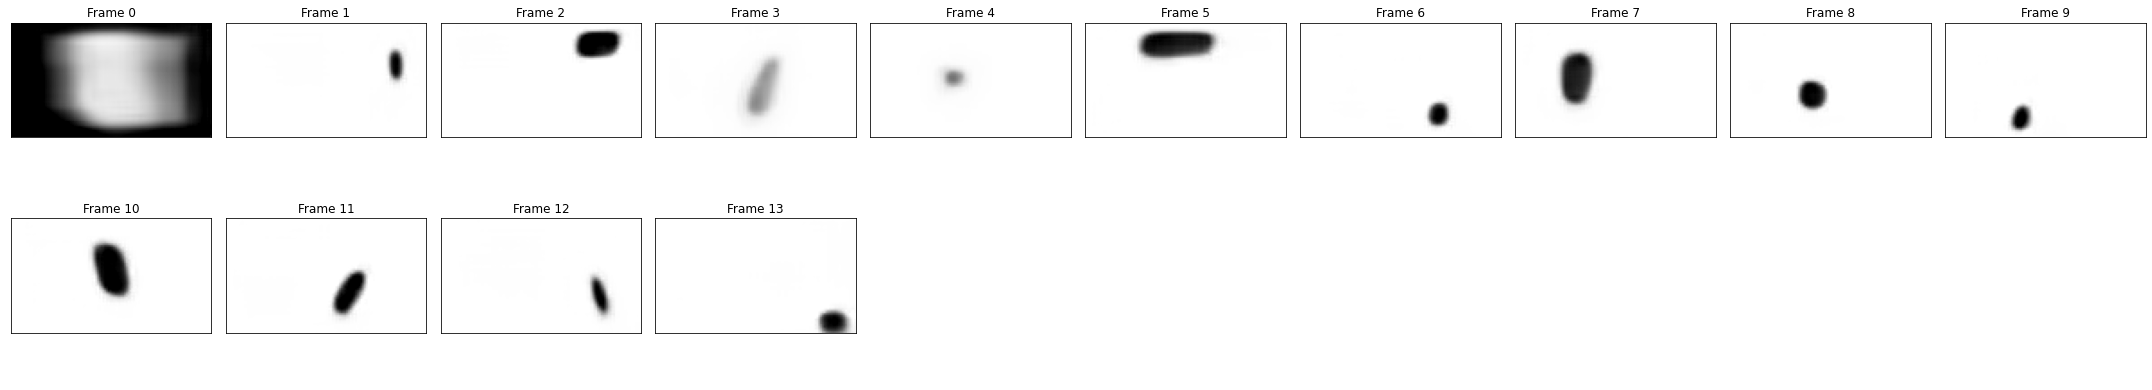

In [37]:
_ = visualizations.visualize_sequence(imgs[0, 0].detach(), n_cols=10, add_axis=False, n_channels=1, cmap="gray_r")
_ = visualizations.visualize_sequence(recons[0, 0].detach(), n_cols=10, add_axis=False, n_channels=1, cmap="gray_r", vmin=0, vmax=1)

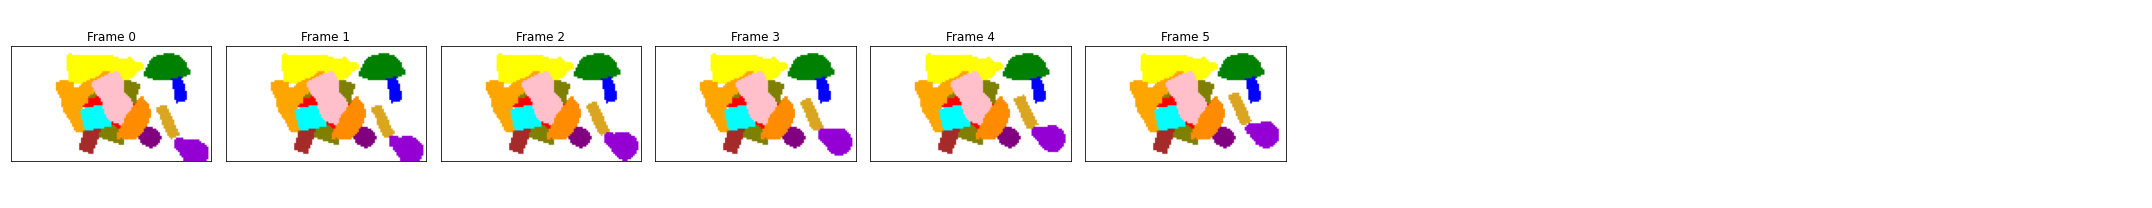

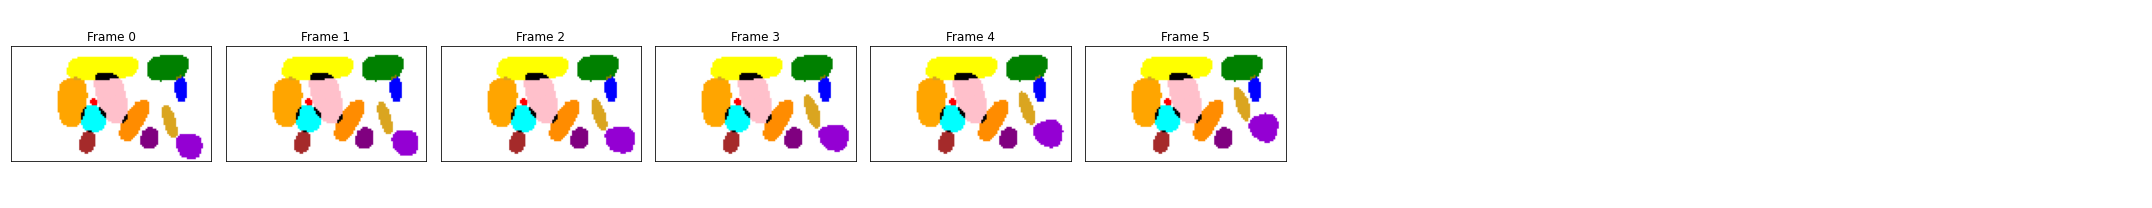

In [39]:
targets = visualizations.one_hot_instances_to_rgb(imgs.detach(), num_channels=14)
recons_rgb = visualizations.one_hot_instances_to_rgb(recons.detach(), num_channels=14)

_ = visualizations.visualize_sequence(targets[1])
_ = visualizations.visualize_sequence(recons_rgb[2])